# Network Representation, Queries, and Manipulation

To understand the how to query and manipulate the network, we'll first cover the various forms of network represenation. Specifically, OpenPNM uses adjacency matrix to represent topology, but occassionally invokes the incidence matrix since this makes it easier for some queries. 

In [212]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

## The Adjacency Matrix

The basic adjacency matrix is an Np-by-Np array of 1's and 0's, where a 1 in location `[i, j]` indicates that pores `i` and `j` are connected. Consider a simple network:

In [213]:
pn = op.network.Cubic(shape=[3, 2, 1], connectivity=26)

It's adjacency matrix can be generated as follows:

In [214]:
am = pn.create_adjacency_matrix().todense()
print(am)

[[0 1 1 1 0 0]
 [1 0 1 1 0 0]
 [1 1 0 1 1 1]
 [1 1 1 0 1 1]
 [0 0 1 1 0 1]
 [0 0 1 1 1 0]]


The adjacency matrix can also be plotted as a image for a helpful visualization:

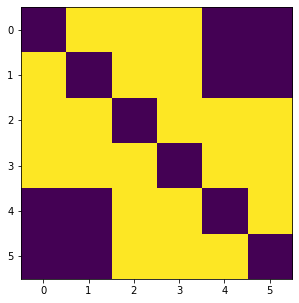

In [215]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
ax.imshow(am);

There are a few notable features to point out:
* The matrix is symmetrical, since pore `i` connects to `j` and `j` connects to `i`
* Each row contains only a few entries since a given pores only has a few neighbors.  It may not be obvious above since the network is small, but as the network grows to millions of pores, each pore only has on the order of 10 neighbors.
* You can find which pores are neighbors of pore `i` by finding the locations on non-zeros in row `i` of the adjacency matrix
* No entries are found in the diagonal since this would indicate that a pore connects with itself which is not very likely
* Since each pair of pores is connected by a single throat then each nonzero entry in the matrix corresponds to a throat

### COO Sparse Format

The fact that each row contains very few entries suggests that the matrix should be represented with a sparse format. This is especially important when we start to consider networks with millions of pores which would require a very large amount of memory to store an array of mostly 0's. The most intuitive sparse storage scheme is the COOrdinate format. Since the matrix is symmetrical, we only need to store the upper (or lower) triangular part.  This gives:

In [216]:
am = pn.create_adjacency_matrix(triu=True)
print(am)

  (0, 1)	1
  (2, 3)	1
  (4, 5)	1
  (0, 2)	1
  (1, 3)	1
  (2, 4)	1
  (3, 5)	1
  (0, 3)	1
  (2, 5)	1
  (1, 2)	1
  (3, 4)	1


The first two columns are the pore indices of the connected pores.  The third column is the value stored in the matrix, which in the standard adjacency matrix is 1.  However, it is convenient to note throat indices are *defined* by this list, meaning that pores 0 and 1 are connected by throat 0, pores 2 and 3 are connected by throat 1, and so on. Putting the throat indices into the adjacency matrix gives:

In [217]:
am = pn.create_adjacency_matrix(weights=pn.Ts, triu=True)
print(am)

  (0, 1)	0
  (2, 3)	1
  (4, 5)	2
  (0, 2)	3
  (1, 3)	4
  (2, 4)	5
  (3, 5)	6
  (0, 3)	7
  (2, 5)	8
  (1, 2)	9
  (3, 4)	10


### Other Sparse Formats

The COO format described above is the basis for OpenPNMs data storage; however, it is not very suitable for performing "queries" such as which pores are neighbors to pore `i`?  In fact, the only query that can be performed directly with the COO format is to find which pores are connected by throat `k`, which is just the `(i, j)` values on row `k`. Luckily, there are several other sparse formats we can use. The "List of Lists" format is quite useful.

We can look for the locations of nonzeros, which tells us which pores are connected to pore `i`:

In [218]:
am = pn.create_adjacency_matrix(weights=pn.Ts, fmt='lil', triu=False)
for locations_of_nonzeros in am.rows:
    print(locations_of_nonzeros)

[1, 2, 3]
[0, 2, 3]
[0, 1, 3, 4, 5]
[0, 1, 2, 4, 5]
[2, 3, 5]
[2, 3, 4]


Note that we are looking at the symmetrical version of this array since we want to see all connections for each pore. 

Or we can look at the values of the nonzeros, which tells us which throats are connected to pore `i`:

In [219]:
for values_of_nonzeros in am.data:
    print(values_of_nonzeros)

[0, 3, 7]
[0, 9, 4]
[3, 9, 1, 5, 8]
[7, 4, 1, 10, 6]
[5, 10, 2]
[8, 6, 2]


Another query we might wish to do is determine which throat connects which pair of pores. The "Dictionary of Keys" format is useful for this.  It is basically the COO format, but the `(i, j)` values are used as the dictionary keys.  This is helpful since dicionary lookups are actually quite fast thanks to some sophisticated data strutures used by python. Consider the following:

In [220]:
am = pn.create_adjacency_matrix(weights=pn.Ts, fmt='dok', triu=False)
print('pores (0, 1):', am[(0, 1)])

pores (0, 1): 0


One *gotcha* with this approach is that if you request the throat that connects two pores which are not connected, then it returns 0, which makes sense if the adjacency matrix is filled with 1's and 0's, but when throat indices are used as the weights, then 0 is a valid throat number, so receiving a 0 back from a query does not indicate lack of connection. This can be remedied by adding 1 to the throat indices when generating the adjacency matrix, then subtracting 1 again to return the actual throat number: 

In [221]:
am = pn.create_adjacency_matrix(weights=pn.Ts+1, fmt='dok', triu=False)
print('pores (5, 5):', am[(5, 5)]-1)

pores (5, 5): -1


## The Incidence Matrix

The incidence matrix is a slight variation on the adjacency matrix, but is it tells us which pore is connected to which throat.  In other words, it is an Np-by-Nt array, with a nonzero value at location `[i, k]` indicating that pore `i` is connected to throat `k`.  It looks like:

In [222]:
im = pn.create_incidence_matrix().todense()
print(im)

[[1 0 0 1 0 0 0 1 0 0 0]
 [1 0 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 0 1 1 0]
 [0 1 0 0 1 0 1 1 0 0 1]
 [0 0 1 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 1 0 0]]


We can see that finding the locations of nonzeros values in row `i` tells us which throats are connected to pore `i`. This is the same information we can get from the COO format of the adjacency matrix. The incidence matrix is thus not really helpful.

## Using OpenPNM Methods Query Methods

The above introduction was meant to provide some background on how neighbor queries are performed "behind the scenes", but it is not very convenient to use those approaches directly. Instead, you can use the methods included in OpenPNM, specifically, the methods attached to the *Network* class:

In [223]:
pn = op.network.Cubic(shape=[4, 4, 1])

Let's start by finding all pores on the 'left' and 'bottom'.  These labels are predefined on `Cubic` networks, and we we cn use the `pores` method to find all pores with these labels:

In [224]:
P_left = pn.pores('left')
P_bottom = pn.pores('back')
print(P_left)
print(P_bottom)

[0 1 2 3]
[ 3  7 11 15]


### Find Neighoring Pores
We now have two sets of pores that actually overlap each other, as illustrated below:

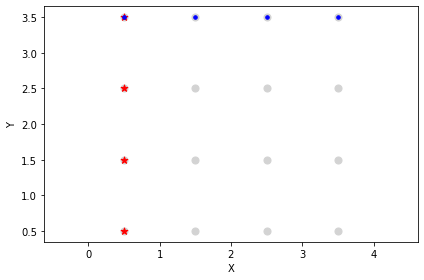

In [225]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P_left, c='red', marker='*', 
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P_bottom, c='blue', marker='.', 
                                  markersize=50, ax=ax);

`mode='or'` finds all pores with one or more connections to the input pores

Given a set of pores, find the pores that are neighbors to one or more of the inputs.  This is called **OR** since it gives the neighbors of either the bottom pores *or* the left pores, *or* both.  

In [226]:
Ps = pn.pores(['left', 'back'])
print(Ps)
Ps = pn.find_neighbor_pores(pores=Ps, mode='or')
print(Ps)

[ 0  1  2  3  7 11 15]
[ 4  5  6 10 14]


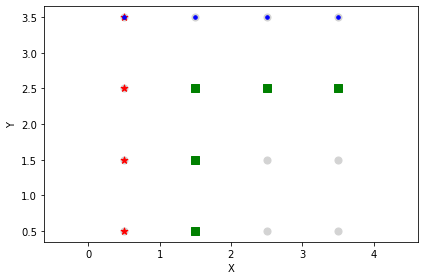

In [227]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey',
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P_left, c='red', 
                                  markersize=50, marker='*', ax=ax)
op.visualization.plot_coordinates(pn, P_bottom, c='blue', 
                                  markersize=50, marker='.', ax=ax)
op.visualization.plot_coordinates(pn, Ps, c='green', 
                                  markersize=50, marker='s', ax=ax);

`mode='xor' finds all pores with exactly one connection to the input pores

Given a set of pores find the pores that are neighbors of one and only one of the input pores.  This is called **XOR**, or 'exclusve_or' because it finds the pores that are neigbhors to the 'bottom' *or* the 'left', but *not* both. 

In [228]:
Ps = pn.pores(['left', 'back'])
print(Ps)
Ps = pn.find_neighbor_pores (pores=Ps, mode='xor')
print(Ps)

[ 0  1  2  3  7 11 15]
[ 4  5 10 14]


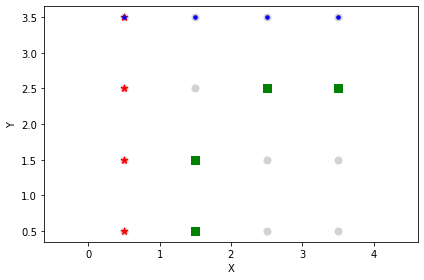

In [229]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey',
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P_left, c='red', 
                                  markersize=50, marker='*', ax=ax)
op.visualization.plot_coordinates(pn, P_bottom, c='blue', 
                                  markersize=50, marker='.', ax=ax)
op.visualization.plot_coordinates(pn, Ps, c='green', 
                                  markersize=50, marker='s', ax=ax);

`mode='xnor'` finds all the pores with 2 or more connections to the input pores

This finds pores that are common to both 'left' and 'bottom' pores.  It is called **XNOR** since it is the opposite of **XOR** , incidated by the *N for not* .   Note that **XNOR** and **NXOR** are interchangable.

In [230]:
Ps = pn.pores(['left', 'back'])
print(Ps)
Ps = pn.find_neighbor_pores(pores=Ps, mode='xnor')
print(Ps)

[ 0  1  2  3  7 11 15]
[6]


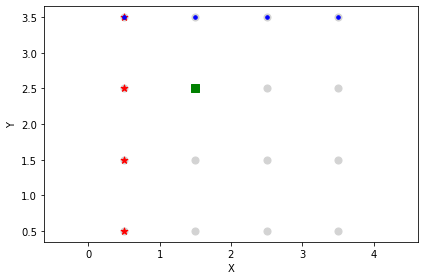

In [231]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P_left, c='red', 
                                  markersize=50, marker='*', ax=ax)
op.visualization.plot_coordinates(pn, P_bottom, c='blue', 
                                  markersize=50, marker='.', ax=ax)
op.visualization.plot_coordinates(pn, Ps, c='green', 
                                  markersize=50, marker='s', ax=ax);

### Find Neighboring Throats
Neighbor throat queries follow essentially the same logic as the neighboring queries outlined above.  

`mode='or'` finds all throats connected to any of the input pores:

In [232]:
Ps = pn.pores(['left', 'back'])
Ts = pn.find_neighbor_throats(pores=Ps, mode='or')

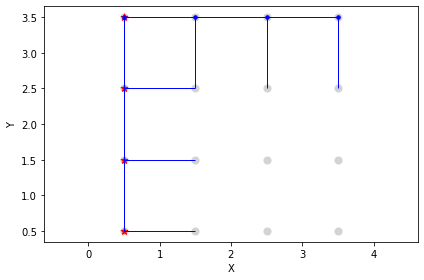

In [233]:
fig, ax = plt.subplots()
op.visualization.plot_connections(pn, Ts, ax=ax)
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P_left, c='red', 
                                  markersize=50, marker='*', ax=ax)
op.visualization.plot_coordinates(pn, P_bottom, c='blue', 
                                  markersize=50, marker='.', ax=ax);

`mode='xnor' finds throats shared by input pores only

In [234]:
Ps = pn.pores(['left', 'back'])
Ts = pn.find_neighbor_throats(pores=Ps, mode='xnor')

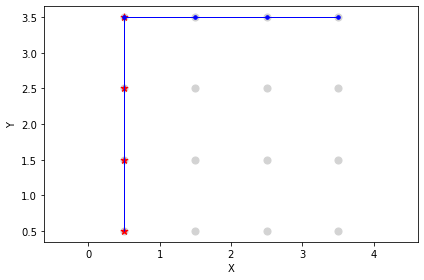

In [235]:
fig, ax = plt.subplots()
op.visualization.plot_connections(pn, Ts, ax=ax)
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P_left, c='red', 
                                  markersize=50, marker='*', ax=ax)
op.visualization.plot_coordinates(pn, P_bottom, c='blue', 
                                  markersize=50, marker='.', ax=ax);

`mode=xor` finds throats that are only connected to one input pore

In [236]:
Ps = pn.pores(['left', 'back'])
Ts = pn.find_neighbor_throats(pores=Ps, mode='xor')

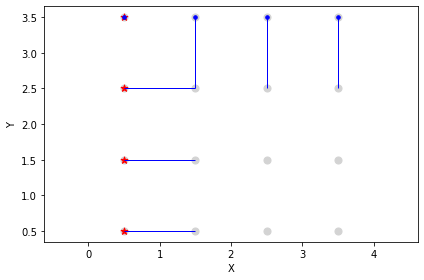

In [237]:
fig, ax = plt.subplots()
op.visualization.plot_connections(pn, Ts, ax=ax)
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P_left, c='red', 
                                  markersize=50, marker='*', ax=ax)
op.visualization.plot_coordinates(pn, P_bottom, c='blue', 
                                  markersize=50, marker='.', ax=ax);

### Find Connecting Throats

Given two sets of pores, it is possible to find which throats connects them using the ``find_connecting_throats``:

In [238]:
P1 = [0, 1, 2, 3]
P2 = [4, 5, 6, 7]
Ts = pn.find_connecting_throat(P1, P2)
print(Ts)

[12 13 14 15]


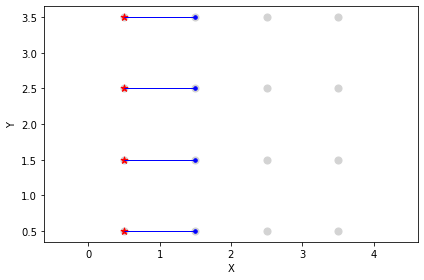

In [239]:
fig, ax = plt.subplots()
op.visualization.plot_connections(pn, Ts, ax=ax)
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_coordinates(pn, P1, c='red', 
                                  markersize=50, marker='*', ax=ax)
op.visualization.plot_coordinates(pn, P2, c='blue', 
                                  markersize=50, marker='.', ax=ax);

This function assumes that `P1` and `P2` are lined up, so that finds the connections between each pore `i`.  If there are no connections, then `nans` are returned (which also means that any valid connections are converted to `float`):

In [240]:
P1 = [0, 1, 2, 3]
P2 = [7, 7, 7, 7]
Ts = pn.find_connecting_throat(P1, P2)
print(Ts)

[nan nan nan 15.]


### Find Connected Pores

Given a list of throats, finding which pores are on either end can be done using the `find_connected_pores` method *or* by looking at `pn['throat.conns']` directly.

In [241]:
Ps = pn.find_connected_pores(throats=[0, 1, 2])
print(Ps)

[[0 1]
 [1 2]
 [2 3]]


In [242]:
Ps = pn['throat.conns'][[0, 1, 2]]
print(Ps)

[[0 1]
 [1 2]
 [2 3]]


It is often desired to have a single column of pore indices and to remove duplications.  This can be done with `np.unique`:

In [243]:
print(np.unique(Ps))

[0 1 2 3]


The `find_connected_pores` method has a `flatten` argument which does the same thing:

In [244]:
Ps = pn.find_connected_pores(throats=[0, 1, 2], flatten=True)
print(Ps)

[0 1 2 3]


## Removing Throats

Removing throats may be useful for a number of reasons such as making a cubic network more heterogeneous, or to study the effect of blockages on flow.  Throat deletion is actualy trivial and requires simply removing the row(s) corresponding to the to-be deleted throats from all throat arrays.  For instance, let's manually delete throats `0` and `3`:

In [245]:
pn = op.network.Cubic(shape=[3, 2, 1])
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x1f7ea245c20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         6 / 6
  2  throat.conns                                                        7 / 7
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                               3
  2  pore.front                                                              3
  3  pore.left                                                               2
  4 

We can see that there are only two arrays which contain throat data, so we need to remove rows 0 and 3 from these. The easiest way to this this actually to "keep" the rows we want:

In [246]:
mask = np.ones(pn.Nt, dtype=bool)
mask[[0, 3]] = False
pn['throat.conns'] = pn['throat.conns'][mask]
pn['throat.surface'] = pn['throat.surface'][mask]
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x1f7ea245c20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         6 / 6
  2  throat.conns                                                        5 / 5
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                               3
  2  pore.front                                                              3
  3  pore.left                                                               2
  4 

If any phases have been defined then they need to be handled as well. OpenPNM includes a function to `trim` throats from networks, which handles any complications:

In [247]:
op.topotools.trim(network=pn, throats=[0, 3])
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x1f7ea245c20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         6 / 6
  2  throat.conns                                                        3 / 3
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.all                                                                6
  2  pore.back                                                               3
  3  pore.front                                                              3
  4 

Visualizing the network shows that throats are indeed missing, and also that some pores are now isolated which is a problem for numerical computations.

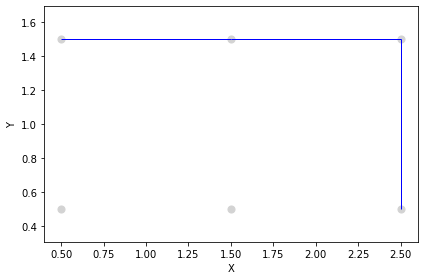

In [248]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, pn.Ps, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_connections(pn, ax=ax);

## Removing Pores
Removing pores is *almost* as easy as removing throats, with **two significant complications**.  

1. When a pore is removed, the values in the `'throat.conns'` array must be updated. If pore 2 is removed, the pore 3 becomes the new pore 2.  This means that any throats which were pointing to pore 3 (i.e. [1, 3]) must now be updated to point to pore 2 instead (i.e. [1, 2]). This can be done manually as shown below, but OpenPNM's `trim` function should be used.
2. A throat cannot point to nothing, so when a pore is deleted, all of it's neighboring throats must also be deleted.

First we'll see how to do this manually, then we'll demonstrate the `trim` function, this time for pores.

The first step is to create an array of 0's with 1's in the locations to be trimmed:

In [249]:
pn = op.network.Cubic(shape=[3, 2, 1])
totrim = np.zeros(pn.Np, dtype=int)
totrim[[2, 4]] = 1
print(totrim)

[0 0 1 0 1 0]


We now compute the cumulative sum of this array which will then contain values indicating by how much each index should be adjusted

In [250]:
offset = np.cumsum(totrim)
print(offset)

[0 0 1 1 2 2]


Lastly we create an array that can be used to remap the throat connections:

In [251]:
remap = pn.Ps - offset
print(remap)

[0 1 1 2 2 3]


Before we proceed with deleting the pores we must first delete the throats. Luckily this is easy, we just need to identify the neighboring throats, the use `trim`:

In [252]:
Ts = pn.find_neighbor_throats(pores=[2, 4])
op.topotools.trim(pn, throats=Ts)

Now we can delete pores 2 and 4 as we did with throats above:

In [253]:
mask = np.ones(pn.Np, dtype=bool)
mask[[2, 4]] = False
for k, v in pn.items():
    if k.startswith('pore.'):
        pn[k] = v[mask]
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x1f7ea249db0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         4 / 4
  2  throat.conns                                                        3 / 3
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.all                                                                4
  2  pore.back                                                               3
  3  pore.front                                                              1
  4 

Lastly we must remap the throat conns:

In [254]:
pn['throat.conns'] = remap[pn['throat.conns']]

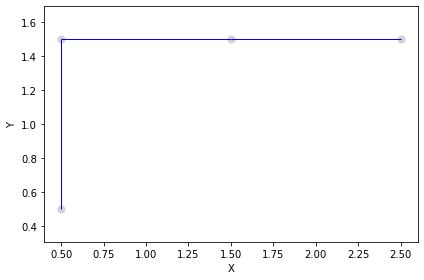

In [255]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_connections(pn, ax=ax);

Of course, the easy way is just to use `trim` directly:

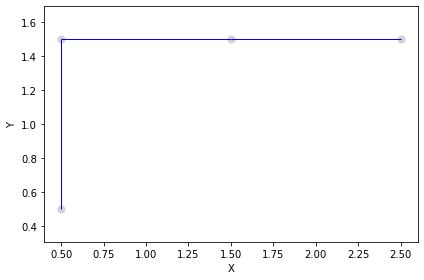

In [256]:
pn = op.network.Cubic(shape=[3, 2, 1])
op.topotools.trim(network=pn, pores=[2, 4])
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_connections(pn, ax=ax);

## Adding Pores and Throats

Adding pores and throats can also be done by hand, but there is one significant complication: when you add a pore or throat, a decision must be made about what values to put into these new locations for all the arrays that already exist. 

This can be done manually as follows:

In [257]:
pn = op.network.Cubic(shape=[3, 2, 1])
new_pores = [[1.5, 2.5, 0.5], [3, 1, 0.5]]
coords = np.vstack((pn['pore.coords'], new_pores))
pn['pore.coords'] = coords
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x1f7ea32dcc0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.coords                                                         8 / 8
  2  throat.conns                                                        7 / 7
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.back                                                               3
  2  pore.front                                                              3
  3  pore.left                                                               2
  4 

We must now extend the length of all the pore arrays as well. We are lucky in this case that only labels are present.  This means we know the shape of of the arrays (i.e. Np-by-1) and we know that `False` is probably the correct value to put into the new locations:

In [258]:
for k in pn.labels():
    if k.startswith('pore.'):
        pn[k] = np.hstack((pn[k], [False, False]))

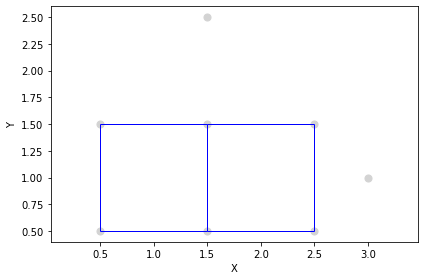

In [259]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_connections(pn, ax=ax);

Now let's add throats to these new pores:

In [260]:
new_conns = [[1, 6], [4, 7], [5, 7]]
conns = np.vstack((pn['throat.conns'], new_conns))
pn['throat.conns'] = conns

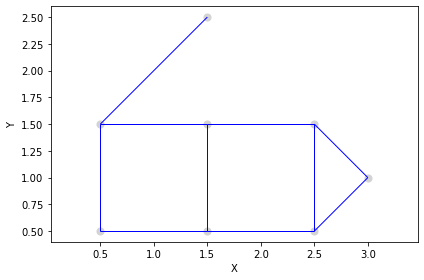

In [261]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_connections(pn, ax=ax);

Obviously, in practice we'd like to use OpenPNM's `extend` method instead:

In [262]:
pn = op.network.Cubic(shape=[3, 2, 1])
new_pores = [[1.5, 2.5, 0.5], [3, 1, 0.5]]
new_conns = [[1, 6], [4, 7], [5, 7]]
op.topotools.extend(network=pn, coords=new_pores)
op.topotools.extend(network=pn, conns=new_conns)

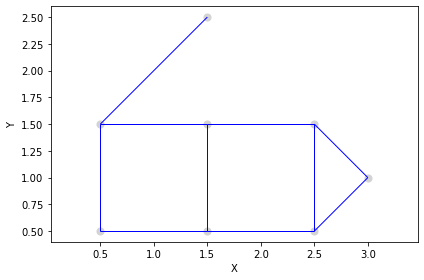

In [263]:
fig, ax = plt.subplots()
op.visualization.plot_coordinates(pn, c='lightgrey', 
                                  markersize=50, ax=ax)
op.visualization.plot_connections(pn, ax=ax);